In [1]:
# Telling matplotlib to work in the program and not as an external window
%matplotlib inline                  
from nptdms import TdmsFile           # Handling TDMS files
import matplotlib.pyplot as plt
#from matplotlib.collections import LineCollection
#import matplotlib as mpl
import numpy as np
import matplotlib.cm as cm
import time
#import scipy
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#import seaborn as sns; import pandas as pd
#import warnings
#from scipy.optimize import OptimizeWarning
plt.rcParams.update({'font.size': 18})
import os, sys                       # For all the stuff which has to do with 
from copy import deepcopy            # To completely copy lists and not references
import cv2                           # OpenCV for video and image procedures
import multiprocessing as mp         # This is for preventing large videos to take too much internal memory
import shutil                        # Deleting folders
import statistics as stats

def vectorlength(x): return np.sqrt(pow(x[0],2)+pow(x[1],2))

def analyseTDMS(file):
    # Print properties and channels of TDMS file
    tdms_file = TdmsFile(file)
    print('Properties (Root):')
    for name, value in tdms_file.object().properties.items():
        print(2*' ' + "{0}: {1}".format(name, value))
    for group in tdms_file.groups():
        print('\'' + group + '\'')
        print(2*' ' + 'Properties (' + '\'' + group + '\'' ')')
        for name, value in tdms_file.object(group).properties.items():
            print('')
        for channel in tdms_file.group_channels(group):
            print(2*' ' + channel.channel)
            
def loadTDMS_Video(file):
    tdms_file = TdmsFile(file)
    p = tdms_file.object().properties
    global dimx, dimy, frames, kinetic_cycle, binning
    dimx = int(p['dimx'])
    dimy = int(p['dimy'])
    frames = int(p['dimz'])
    kinetic_cycle = float(p['kinetic_cycle'])
    binning = int(p['binning'])
    images = tdms_file.channel_data('Image','Image')
    return images.reshape(frames, dimx, dimy)

def loadTDMSImages(file):
    global exposure, dimx, dimy
    tdms_file = TdmsFile(file)
    p=tdms_file.object().properties   
    dimx=int(p['dimx'])  
    dimy=int(p['dimy'])
    frames=int(p['dimz'])
    exposure=float(p['exposure'])
    images=tdms_file.channel_data('Image','Image')
    return images.reshape(frames,dimx,dimy)

## Load the ..._module.tdms file from the folder

In [2]:
number=3                                                              #Which number of the files
folder = "/Users/alex/Documents/Measurements/200625 - Test Alex"      #Which folder
loadvideofile = False                                                 #Load the video file?
if loadvideofile == False:
    dt = 0.05
    videosize = 512

pxtomum=0.0533#0.0719e-6
R = 2.19e-6/2
T = 273.15+22
kB = 1.38064852e-23
eta=2.414e-5*10**(247.8/(T-140))
D_0 = kB*T/(6*np.pi*eta*R)  #D_0 = 3.85e-14

start_time = time.time()   
if number < 10:
        tdms_file = TdmsFile(folder+"/Test_00"+str(number)+"_module.tdms")
        analyseTDMS(folder+"/Test_00"+str(number)+"_module.tdms")
        if loadvideofile == True:
            tdms_file = loadTDMS_Video(folder+"/Test_00"+str(number)+"_module.tdms")
else:
    if number < 100:
        tdms_file = TdmsFile(folder+"/Test_0"+str(number)+"_module.tdms")
        analyseTDMS(folder+"/Test_0"+str(number)+"_module.tdms")
        if loadvideofile == True:
            tdms_file = loadTDMS_Video(folder+"/Test_0"+str(number)+"_module.tdms")
    else:
        tdms_file = TdmsFile(folder+"/Test_"+str(number)+"_module.tdms")
        analyseTDMS(folder+"/Test_"+str(number)+"_module.tdms")
        if loadvideofile == True:
            tdms_file = loadTDMS_Video(folder+"/Test_"+str(number)+"_module.tdms")
print("--- %s seconds ---" % round((time.time() - start_time),2))

Xc = tdms_file.channel_data('Data','Xc')
Yc = tdms_file.channel_data('Data','Yc')
velocitytheo = tdms_file.channel_data('Data','Velocity')
angletheo = tdms_file.channel_data('Data','Angle')
xolaser = tdms_file.channel_data('Data','Xh')
yolaser = tdms_file.channel_data('Data','Yh')
Nfound = tdms_file.channel_data('Data','N')
Nfound -= 1                     #WHYYYYYY IS THERE STILL AN ERROR??????
p = tdms_file.object().properties
delay = int(p['Delay'])
noise = int(p['Sigmanoise'])
boundaryradius = p['Boundary']
offset = p['Offset']
sigma = p['Sigmavelo']
vmin = p['Vmin']
vmax = p['Vmax']
vfactor = vmax - vmin
maxlength = len(Nfound)
if loadvideofile == True:
    dt = kinetic_cycle
    videosize = dimx
timewave=np.linspace(0,maxlength*dt,maxlength)

print('size of the video = ',videosize)
print('length of the movie = ',maxlength)

Properties (Root):
  Boundary: 200.0
  Delay: 1
  Offset: -14.0
  Sigmanoise: 10.0
  Sigmavelo: 1.0
  Tau_r: 0.1
  Threshold: 5000
  Vmax: 1.0
  Vmin: 0.2
'Data'
  Properties ('Data')
  Angle
  N
  Velocity
  Xc
  Xh
  Yc
  Yh
--- 1.2 seconds ---
size of the video =  512
length of the movie =  819


## Sort the trajectories

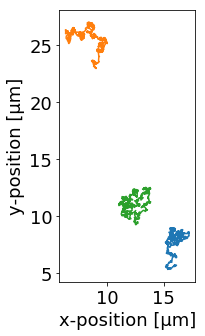

In [3]:
number = int(stats.mode(Nfound))
maxnumber = int(max(Nfound))

particles = np.zeros((maxlength,number,6))
lastone = np.zeros((number,2))
pre = np.zeros((maxlength,maxnumber,6))
count = 0
for i in range(maxlength):
    for j in range(int(Nfound[i])):
        pre[i,j,0] = Xc[count]
        pre[i,j,1] = Yc[count]
        pre[i,j,2] = velocitytheo[count]
        pre[i,j,3] = angletheo[count]
        pre[i,j,4] = xolaser[count]
        pre[i,j,5] = yolaser[count]
        count += 1

particles[0,:,:] = pre[0,:number,:]
for i in range(1,maxlength):
    for j in range(number):
        if particles[i-1,j,0] != 0:
            lastone[j,0] = i-1
            lastone[j,1] = 0
        else: lastone[j,1] += 1
        xpre = particles[int(lastone[j,0]),j,0]
        ypre = particles[int(lastone[j,0]),j,1]
        mindist = 10; minnum = 666
        for k in range(int(Nfound[i])):     #Sort the trajectories be comparing the distance between the positions
            dist = np.sqrt(pow(xpre-pre[i,k,0],2)+pow(ypre-pre[i,k,1],2))
            if dist < mindist:
                mindist = dist
                minnum = k
                #print('i = ',i,' - j = ',j,' - mindist = ',round(mindist,1),' - minnum = ',minnum)
        if minnum != 666: particles[i,j,:] = pre[i,minnum,:]
        
for i in range(1,maxlength):
    for j in range(number):
        if particles[i,j,0] == 0:
            particles[i,j,0] = np.nan
            particles[i,j,1] = np.nan     
particles[:,:,0:2] *= pxtomum

fig=plt.figure(1, figsize = (5,5) )
ax = plt.subplot(1,1,1)
ax.set_aspect('equal')
for i in range(3):
    ax.plot(particles[:,i,0],particles[:,i,1])
plt.xlabel('x-position [µm]')
plt.ylabel('y-position [µm]')
plt.show()

## Calculate the velocities and plot the histogram

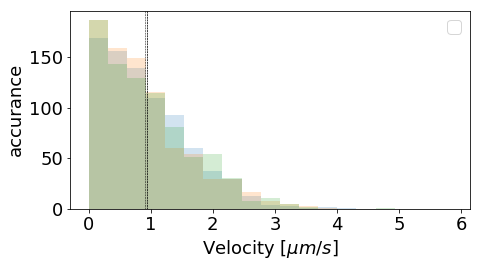

velocity particle 0 : 0.93  µm/s
velocity particle 1 : 0.91  µm/s
velocity particle 2 : 0.94  µm/s


In [5]:
directionvector = np.zeros((maxlength,2))
movingvector = np.zeros((maxlength,2))
velocity = np.zeros((maxlength,number));stepsize = np.zeros(maxlength)
velocitywithdiffusion=np.zeros((maxlength,number))
velocity2 = np.zeros((maxlength,number,2))

for j in range(number):
    directionvector[:,0] = np.cos(particles[:,j,2]*np.pi/180)
    directionvector[:,1] = np.sin(particles[:,j,2]*np.pi/180)
    for i in range(1,maxlength):                           #Calc projection of the velocity in the required direction
        movingvector[i,0] = particles[i,j,0]-particles[i-1,j,0]
        movingvector[i,1] = particles[i,j,1]-particles[i-1,j,1]
        stepsize[i] = abs(np.dot(directionvector[i,:], movingvector[i,:]))
        velocity[i,j] = stepsize[i]/dt
        velocitywithdiffusion[i,j] = np.sqrt(pow(movingvector[i,0],2)+pow(movingvector[i,1],2))/dt 
        distance = np.sqrt(pow(particles[i,j,0],2)+pow(particles[i,j,1],2))
        if distance < boundaryradius*pxtomum:
            velocity2[i,j,0] = velocity[i,j]
            velocity2[i,j,1] = velocitywithdiffusion[i,j]
for j in range(number):
    for i in range(maxlength):
        if velocity2[i,j,0] == 0: velocity2[i,j,:]=np.nan
        
binwave=np.linspace(np.amin(velocity),min(np.amax(velocitywithdiffusion),10),20)
fig=plt.figure(1, figsize = (7,4) )
plt.subplot(1,1,1)
for i in range(number):
    wave = velocity[:,i]    
    plt.hist(wave[~np.isnan(wave)], bins=binwave,alpha = 0.2)
    plt.axvline(x=np.nanmean(wave),linewidth=0.5, color = 'k',linestyle='--')
plt.xlabel('Velocity [$\mu m/s$]')
plt.ylabel('accurance')
#plt.text(3,0,'mean step size 1: {:.2f} µm/s'.format(np.mean(velocity)),fontsize=12)
plt.legend()
plt.tight_layout() 
#plt.savefig('Histogram Stepsize'+str(num)+'.pdf', format='pdf')
plt.show() 

for i in range(number): print('velocity particle',str(i),':',round(np.mean(velocity[:,i]),2),' µm/s')

## Calculate the distance between the particles

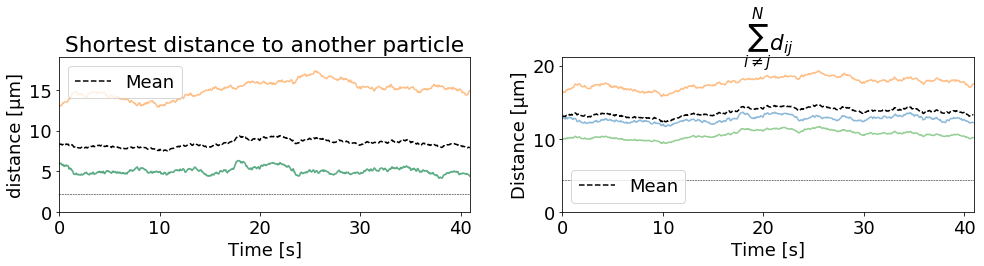

In [19]:
timewave = np.linspace(0,dt*maxlength,maxlength,endpoint=False)
mindistance = np.zeros((number,maxlength))
adddist = np.ones((number,maxlength))
for i in range(maxlength):
    for j in range(number):
        dist = 666*np.ones(number)
        for k in range(number):
            if j != k:
                here = np.sqrt(pow(particles[i,j,0]-particles[i,k,0],2)+pow(particles[i,j,1]-particles[i,k,1],2))
                adddist[j,i] += here
                dist[k] = here
        mindistance[j,i] = np.min(dist)
adddist /= 2

meanmindist = np.zeros(maxlength)
for i in range(maxlength):
    meanmindist[i] = mean(mindistance[:,i])
meandist = np.zeros(maxlength)
for i in range(maxlength):
    meandist[i] = mean(adddist[:,i])
    
fig=plt.figure(1, figsize = (14,4) )
plt.subplot(1,2,1)
for i in range(number):
    plt.plot(timewave,mindistance[i,:],alpha = 0.5)
plt.plot(timewave,meanmindist,'k--',label='Mean')
plt.xlabel('Time [s]')
plt.ylabel('distance [µm]')
plt.title('Shortest distance to another particle')
plt.xlim(0,dt*maxlength)
plt.ylim(0,1.1*mindistance.max())
plt.axhline(y=R*2*1e6,linewidth=0.5, color = 'k',linestyle='--')
plt.legend()

plt.subplot(1,2,2)
for i in range(number):
    plt.plot(timewave,adddist[i,:],alpha = 0.5)
plt.plot(timewave,meandist,'k--',label='Mean')
plt.xlabel('Time [s]')
plt.ylabel('Distance [µm]')
plt.title(r'$\sum_{i\neq j}^{N} d_{ij}$')
plt.xlim(0,dt*maxlength)
plt.ylim(0,1.1*adddist.max())
plt.axhline(y=(number-1)*R*2*1e6,linewidth=0.5, color = 'k',linestyle='--')
plt.legend()
plt.tight_layout() 
plt.savefig('Distance.pdf', format='pdf')
plt.show()

## If the video file is loaded it can be saved as a avi-file

In [17]:
string_images = folder+"/Test_00"+str(number)+"_video.tdms"
string_folder = ''
if not string_folder == '':
    string_folder += '/'
    with_features = 1
else:
    with_features = 0
    
# Frame rate of the generated movie (in frames per second)
Frame_Rate_Movie = 1/dt
    
# Getting the folder where the measurement data are stored in
place = 0
for i in range(len(string_images)):
    if string_images[i] == '/':
        place = i
folder = string_images[0:place + 1]

if with_features == 0:
    string_folder = folder

# Opens TDMS files and stores the main properties as well as the image series in variables, lists
tdms_file = TdmsFile(string_images)
# All information from the corresponding file
file_info = tdms_file.object()
# Getting the properties of the TDMS file, the strings come from the program 
# generating the TDMS files
temp = file_info.properties
pixel_x = int(temp['dimx'])    # Converting the properties to integers
pixel_y = int(temp['dimy'])
# Saves the number of frames which were adjusted before
number_frames_adjusted = int(temp['dimz'])
parameters = np.zeros(5)
parameters[0] = float(temp['exposure'])    # Saving the exposure time, [s]
parameters[1] = int(temp['binning'])
parameters[2] = int(pixel_x)
parameters[3] = int(pixel_y)
# Getting the image data
image = tdms_file.channel_data('Image', 'Image')
# Getting the number of frames really recorded
number_frames = int(image.shape[0]/pixel_x/pixel_y)
parameters[4] = number_frames
# Generating the image series
series = image.reshape(number_frames, pixel_x, pixel_y)

if with_features == 1:
    # Open the feature files
    files = os.listdir(string_folder)
    for i in range(len(files)):
        # Opening the x-data
        if files[i][0] == 'x':
            x_data = np.array([])
            with open(string_folder + files[i], "rb") as x_dat:
                while 1:
                    try:
                        x_data = np.append(x_data, pickle.load(x_dat))
                    except EOFError:
                        break
        # Opening the y-data
        if files[i][0] == 'y':
            y_data = np.array([])
            with open(string_folder + files[i], "rb") as y_dat:
                while 1:
                    try:
                        y_data = np.append(y_data, pickle.load(y_dat))
                    except EOFError:
                        break
    
        # Opening the file containing the number of particles which is then used for reshaping the two arrays from above
        if files[i][0:3] == 'max':
            number_particles = np.array([])
            with open(string_folder + files[i], "rb") as num:
                while 1:
                    try:
                        number_particles = np.append(number_particles, pickle.load(num))
                    except EOFError:
                        break
    
        # Taking care that probably not all of the original data were taken in the previous program
        if files[i][0:8] == 'range_of':
            range_data = np.array([])
            with open(string_folder + files[i], "rb") as r:
                while 1:
                    try:
                        range_data = np.append(range_data, pickle.load(r))
                    except EOFError:
                        break
            lower_bound = int(range_data[0])
            upper_bound = int(range_data[1])
        
            series = series[lower_bound:upper_bound]
            number_frames = len(series)

        # Taking care that probably only a substack is loaded
        if files[i][0:11] == 'range_stack':
            range_data = np.array([])
            with open(string_folder + files[i], "rb") as r:
                while 1:
                    try:
                        range_data = np.append(range_data, pickle.load(r))
                    except EOFError:
                        break
            lower_bound = int(range_data[0])
            upper_bound = int(range_data[1])
        
            series = series[lower_bound:upper_bound]
            number_frames = len(series)
            
    # Generating the original shape of the data
    x_data = x_data.reshape(int(len(x_data)/number_particles[0]), int(number_particles[0]))
    y_data = y_data.reshape(int(len(y_data)/number_particles[0]), int(number_particles[0]))

In [27]:
# Generating the movie
radiuslaser = 5
#colorwave = cm.rainbow(np.linspace(0, 1, maxparticle))

# Working function generating the images, cf. below.
def worker():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim([0, pixel_x])
    ax.set_ylim([0, pixel_y])
    plt.axis('off')
    im = plt.imshow(series_copy[i,:,:], cmap=plt.get_cmap('gray'))

    #circlelaser = plt.Circle((xlaser[i,0],ylaser[i,0]), radius=radiuslaser, color='y')
    #ax.add_artist(circlelaser)
        
    fig.savefig(string_temp + '/test ' + str(i) + '.png')
    plt.close(fig)

# Folder containing the movie
if not os.path.exists(string_folder + str('Movie')):
    os.makedirs(string_folder + str('Movie'))
# Temporary folder containing the images. Is going to be removed after the preparation of the movie
string_temp = string_folder + 'Movie/' + 'temporary' 
if not os.path.exists(string_temp):
    os.makedirs(string_temp)

series_copy = deepcopy(series)

# Preparing all for setting up the movie in a kind of circumstantial manner
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim([0, pixel_x])
ax.set_ylim([0, pixel_y])
ax.set_ylim(ax.get_ylim()[::-1])
data = series_copy[0,:,:]
plt.axis('off')
im = plt.imshow(data, cmap=plt.get_cmap('gray'))
fig.savefig(string_temp + '/test ' + str(0) + '.png')
plt.close(fig)                                                        # Immediatelly, suppressing drawing
              
img_temp = cv2.imread(string_temp + '/test ' + str(0) + '.png')
height, width, layers = img_temp.shape 
video = cv2.VideoWriter(string_folder + str('Movie') + '/Movie_tracked.avi',cv2.VideoWriter_fourcc(*'MJPG'),Frame_Rate_Movie,(width,height))

# Saving the images in a temporary folder. Since the library matplotlib does not correctly de-reference closed images,
# they remain in the internal memory causing an overflow for large movies. That is why this for loop calls for the 
# generation of every image a new process which is closed when finishing which certainly frees the occupied internal
# memory. 
for i in range(number_frames):   
    if __name__=='__main__':
        proc=mp.Process(target=worker)
        proc.daemon=True
        proc.start()
        proc.join()

    # Updating progress
    sys.stdout.write(("\r Preparing images: [ %d"%int(i/number_frames*100 + 1)+"% ] "))
    sys.stdout.flush()
    
# Making the movie
for i in range(number_frames-1):
    im_temp = cv2.imread(string_temp + '/test ' + str(i) + '.png')
    video.write(im_temp)
        
    # Updating progress
    sys.stdout.write(("\r Generating the movie: [ %d"%int(i/number_frames*100 + 1)+"% ] "))
    sys.stdout.flush()

cv2.destroyAllWindows()
video.release()
# Deleting the temporary folder
shutil.rmtree(string_temp)

 Generating the movie: [ 100% ] 

NameError: name 'shutil' is not defined

In [28]:
    fig = plt.figure(1, figsize = (10,5))
    ax = plt.subplot(1, 2, 1)
    plt.imshow(images[0], cmap='gray');
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
    print(Xc[:4])